In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"c:\Users\tanuj\Downloads\Assessment-2-Associate-DS.csv")

# **Data Cleaning**

In [3]:
def clean_data(df):
    df["weekend_date"] = df["weekend_date"].astype(str).str[:10]  
    df["weekend_date"] = pd.to_datetime(df["weekend_date"])  
    df = df.sort_values(by="weekend_date")  
    df.set_index("weekend_date", inplace=True)  
    
    return df

In [4]:
df = clean_data(df)

In [5]:
df_new = df[["quantity"]]

In [6]:
df_new = pd.DataFrame(df_new.groupby(df_new.index)["quantity"].sum())

# **Feature Creations**

In [7]:
def feature_engineering(df):
    df["day"] = df.index.day
    df["month"] =df.index.month
    df["year"] = df.index.year
    df["year"] = df.index.year
    df["week"] = df.index.isocalendar().week
    df["week"] = df["week"].astype("float") 

    # Lag Features (past sales as features)

    df['lag_1'] = df['quantity'].shift(1)
    df['lag_2'] = df['quantity'].shift(2)
    df['lag_3'] = df['quantity'].shift(3)


    df["rolling_mean_4"] = df["quantity"].rolling(window=4).mean()
    df["rolling_std_4"] = df["quantity"].rolling(window=4).std()   


    return df

In [8]:
df_new = feature_engineering(df_new)

In [9]:
df_new.dropna(inplace=True)

# **Removing Outliars**

In [10]:
def outliars_removal(df,col):
    Q1 = df["quantity"].quantile(.25)
    Q3 = df["quantity"].quantile(.75)
    IQR = Q3 - Q1

    lower_limit = Q1 + 1.5 * IQR
    upper_limit = Q3 - 1.5* IQR

    df[col] = df[col].clip(lower_limit,upper_limit)

    return df

In [11]:
df_new = outliars_removal(df_new,"quantity")

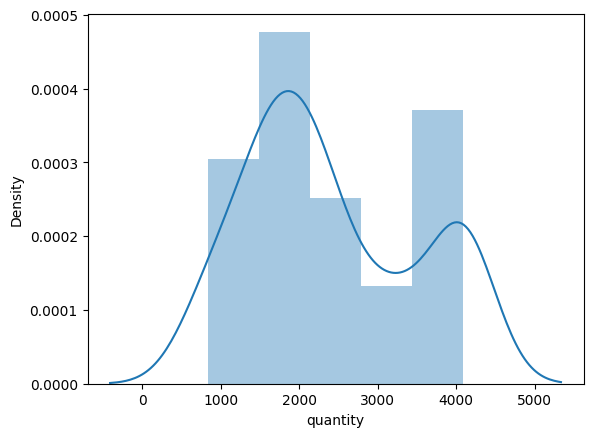

In [12]:
sns.distplot(df_new["quantity"],kde=True)
plt.show()

# **Weekly Quantity Trends**

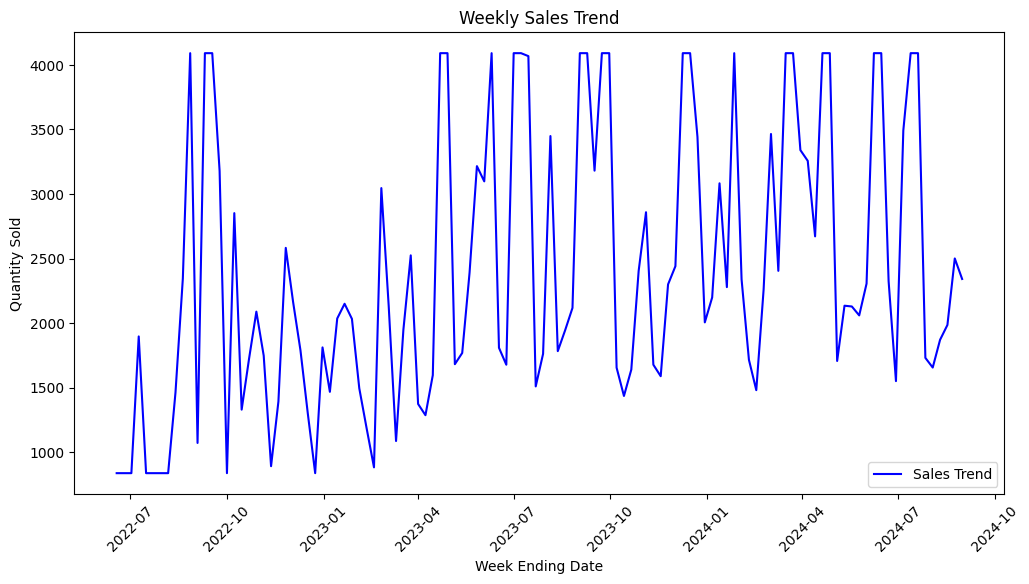

In [13]:
plt.figure(figsize=(12, 6))

# Line Plot (Ensuring x-axis is properly set)
sns.lineplot(x=df_new.index, y=df_new["quantity"], label="Sales Trend", color="blue")


plt.title('Weekly Sales Trend')
plt.xlabel('Week Ending Date')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [14]:
df_new.columns

Index(['quantity', 'day', 'month', 'year', 'week', 'lag_1', 'lag_2', 'lag_3',
       'rolling_mean_4', 'rolling_std_4'],
      dtype='object')

# **Splitting Data**

In [15]:
# Define train and test split date
split_date = pd.Timestamp("2024-06-01")
train = df_new[df_new.index < split_date]
test = df_new[df_new.index >= split_date]

In [16]:
print(train.shape)
print(test.shape)

(102, 10)
(14, 10)


In [17]:
features = ['day', 'month', 'year', 'week', 'lag_1', 'lag_2', 'lag_3',
       'rolling_mean_4', 'rolling_std_4']
target = "quantity"

# **Creating ARIMA Model as no seasonality in Data**

**Selecting d value**

In [18]:
# Perform the Augmented Dickey-Fuller (ADF) test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary")

adf_test(df_new["quantity"]) # d = 0


ADF Statistic: -6.362051109766528
p-value: 2.460746547871133e-08
Data is stationary


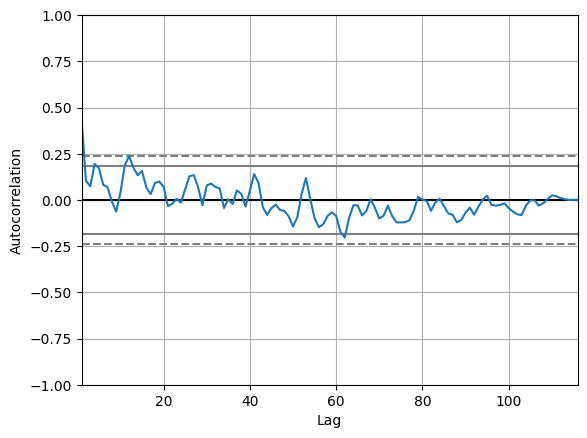

In [19]:
autocorrelation_plot(df_new["quantity"]) #q= 0,1
plt.show()

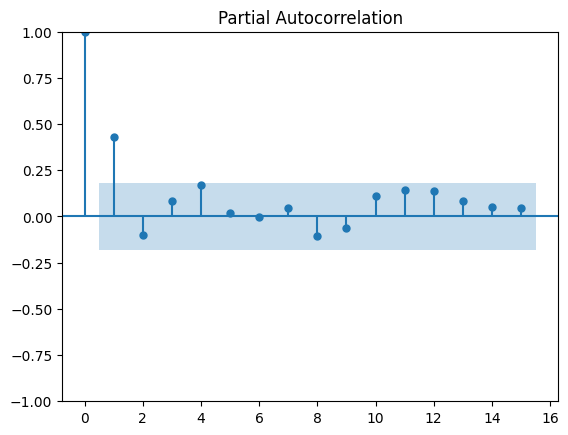

In [20]:
plot_pacf(df_new[target], lags=15)
plt.show()  #p=1

In [21]:
df_new.dtypes

quantity          float64
day                 int32
month               int32
year                int32
week              float64
lag_1             float64
lag_2             float64
lag_3             float64
rolling_mean_4    float64
rolling_std_4     float64
dtype: object

In [54]:
arima_model = ARIMA(train[target], exog=train[features], order=(1, 0, 0)) # p,d,q
arima_model_fit = arima_model.fit()

In [55]:
# Forecast
arima_forecast = arima_model_fit.forecast(steps=len(test), exog=test[features])

In [56]:
# Add forecast to test set
test['Validation_data'] = np.array(arima_forecast)

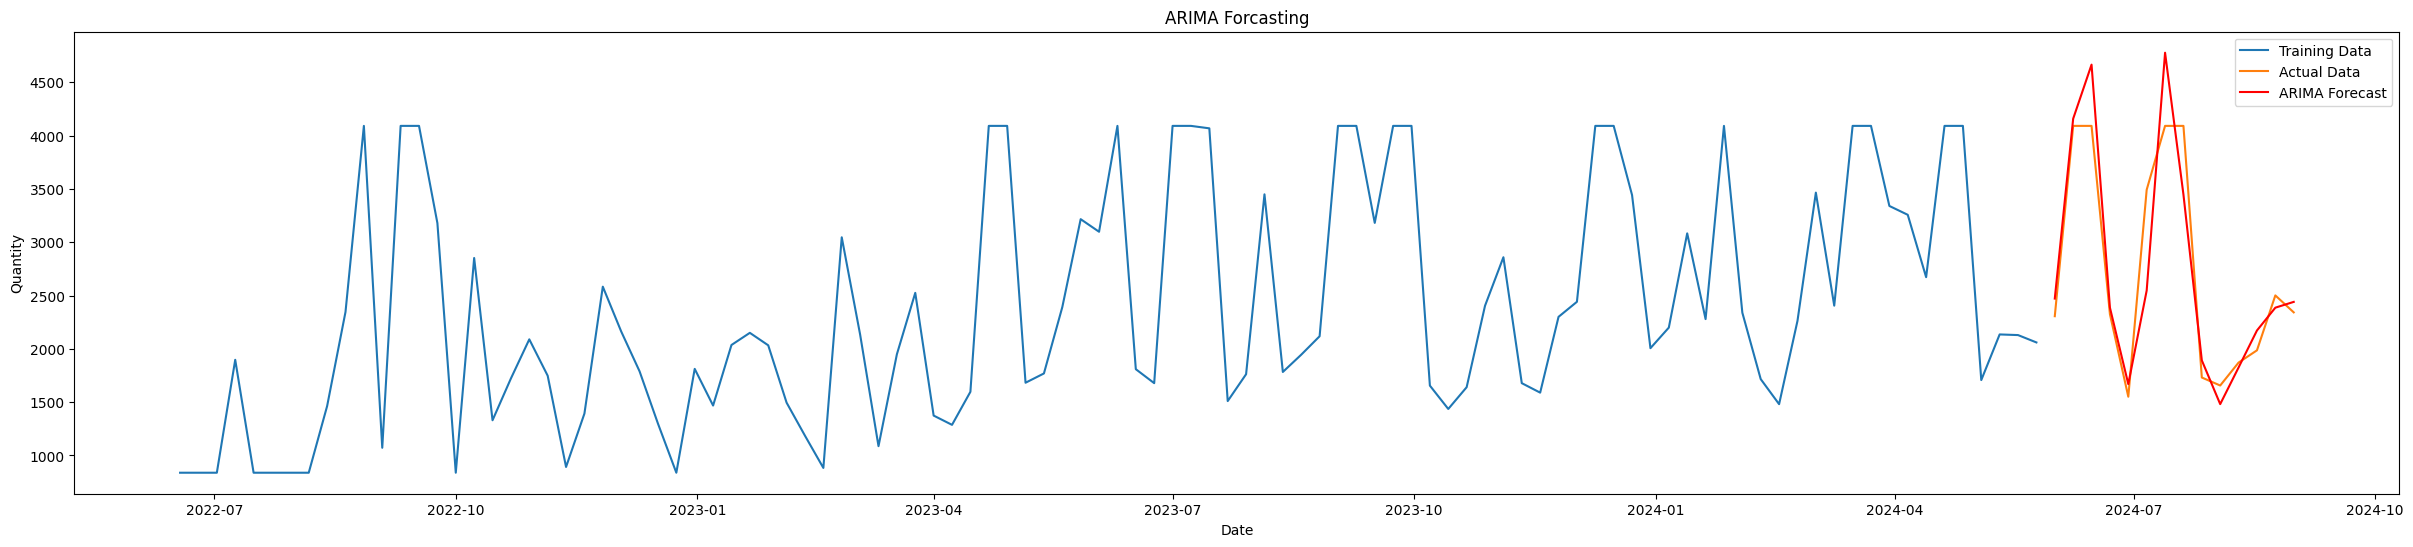

ARIMA Mean Squared Error: 162463.20300963754


In [57]:
# Plot results
plt.figure(figsize=(30, 6))
plt.plot(train['quantity'], label='Training Data')
plt.plot(test['quantity'], label='Actual Data')
plt.plot(test['Validation_data'], label='ARIMA Forecast', color='red')
plt.title('ARIMA Forcasting')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Evaluate model
mse_arima = mean_squared_error(test['quantity'], arima_forecast)
print(f'ARIMA Mean Squared Error: {mse_arima}')

# **Evaluation**

In [58]:
mse_arima

162463.20300963754

In [59]:
RMSE= np.sqrt(mse_arima)
print(RMSE)

403.0672437815278


# **Forcasting for next 3 Months**

In [60]:
# Forecast next 12 weeks
future_weeks = 12
future_dates = pd.date_range(start=df_new.index[-1], periods=future_weeks+1, freq='W')[1:]


future_exog = pd.DataFrame({
    "day": future_dates.day,
    "month": future_dates.month,
    "year": future_dates.year,
    "week": future_dates.isocalendar().week
})


future_exog["lag_1"] = df_new[target].iloc[-1]
future_exog["lag_2"] = df_new[target].iloc[-2]
future_exog["lag_3"] = df_new[target].iloc[-3]

future_exog["rolling_mean_4"] = df_new[target].iloc[-4:].mean()
future_exog["rolling_std_4"] = df_new[target].iloc[-4:].std()

# Ensure column order
future_exog = future_exog[features]

In [61]:
future_exog.index = pd.to_datetime(future_exog.index)
future_exog["week"] = future_exog["week"].astype("float")

In [62]:
future_exog.head()

,day,month,year,week,lag_1,lag_2,lag_3,rolling_mean_4,rolling_std_4
2024-09-08,8,9,2024,36.0,2342.0,2501.0,1986.0,2175.0,295.692408
2024-09-15,15,9,2024,37.0,2342.0,2501.0,1986.0,2175.0,295.692408
2024-09-22,22,9,2024,38.0,2342.0,2501.0,1986.0,2175.0,295.692408
2024-09-29,29,9,2024,39.0,2342.0,2501.0,1986.0,2175.0,295.692408
2024-10-06,6,10,2024,40.0,2342.0,2501.0,1986.0,2175.0,295.692408


In [63]:
# Forecast
arima_pred = arima_model_fit.forecast(steps=len(future_exog), exog=future_exog)

In [64]:
future_dates = pd.date_range(start=df_new.index[-1], periods=future_weeks+1, freq='W')[1:]

In [65]:
Arima_pred = pd.DataFrame({
    "date" : future_dates,
    "arima_pred" : arima_pred
})

Arima_pred.set_index("date",inplace=True)


In [66]:
Arima_pred

,arima_pred
date,
2024-09-08,2240.399115
2024-09-15,2229.984735
2024-09-22,2238.978172
2024-09-29,2246.731326
2024-10-06,2260.852493
2024-10-13,2268.679843
2024-10-20,2276.507517
2024-10-27,2284.335171
2024-11-03,2203.901936


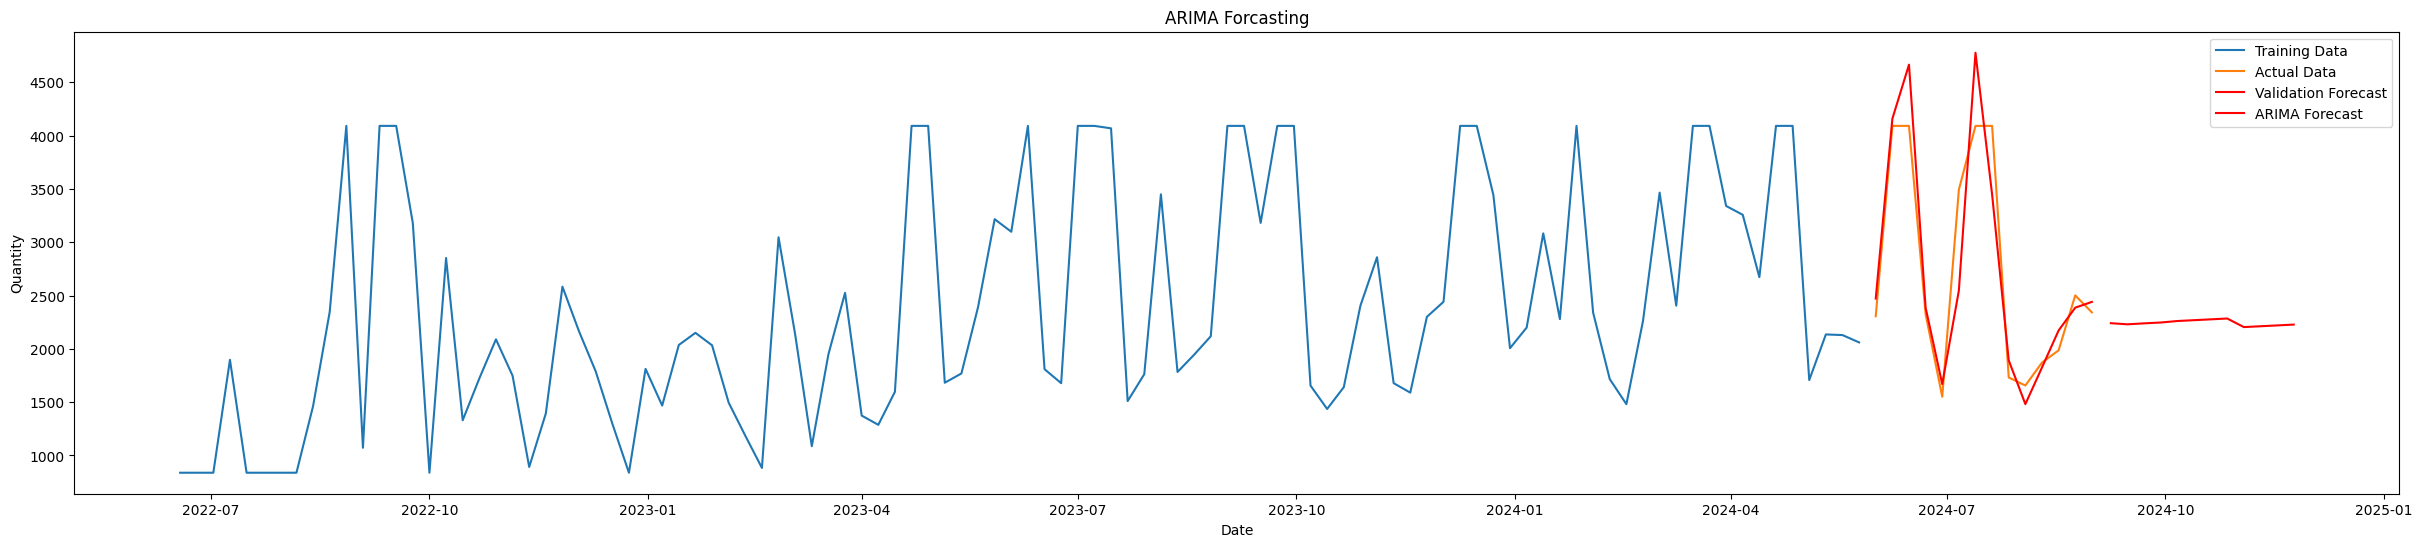

In [67]:
# Plot results
plt.figure(figsize=(30, 6))
plt.plot(train['quantity'], label='Training Data')
plt.plot(test['quantity'], label='Actual Data')
plt.plot(test['Validation_data'], label='Validation Forecast', color='red')
plt.plot(Arima_pred['arima_pred'], label='ARIMA Forecast', color='red')
plt.title('ARIMA Forcasting')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# **Monthly Accuracy**

In [68]:
monthly_actual = test.groupby(test.index.month)['quantity'].sum()
monthly_pred = test.groupby(test.index.month)['Validation_data'].sum()

In [69]:
mse = mean_squared_error(monthly_actual.values,monthly_pred.values)
rmse = np.sqrt(mse)
print(rmse)

713.1969463667673


**Save the model**

In [ ]:
joblib.dump(model, "random_forest_model.pkl")

# **Thank You**